In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [40]:
widht = 75
height = 75

In [41]:
PATH = "Rock-Paper-Scissors/"
train_dir = os.path.join(PATH+"train")
train = keras.preprocessing.image_dataset_from_directory(train_dir,image_size=(widht,height),seed=20,validation_split=0.2,subset="training")
validation = keras.preprocessing.image_dataset_from_directory(train_dir,image_size=(widht,height),seed=20,validation_split=0.2,subset="validation")
test_dir = os.path.join(PATH,"test")
test = keras.preprocessing.image_dataset_from_directory(test_dir,image_size=(widht,height))

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.
Found 372 files belonging to 3 classes.


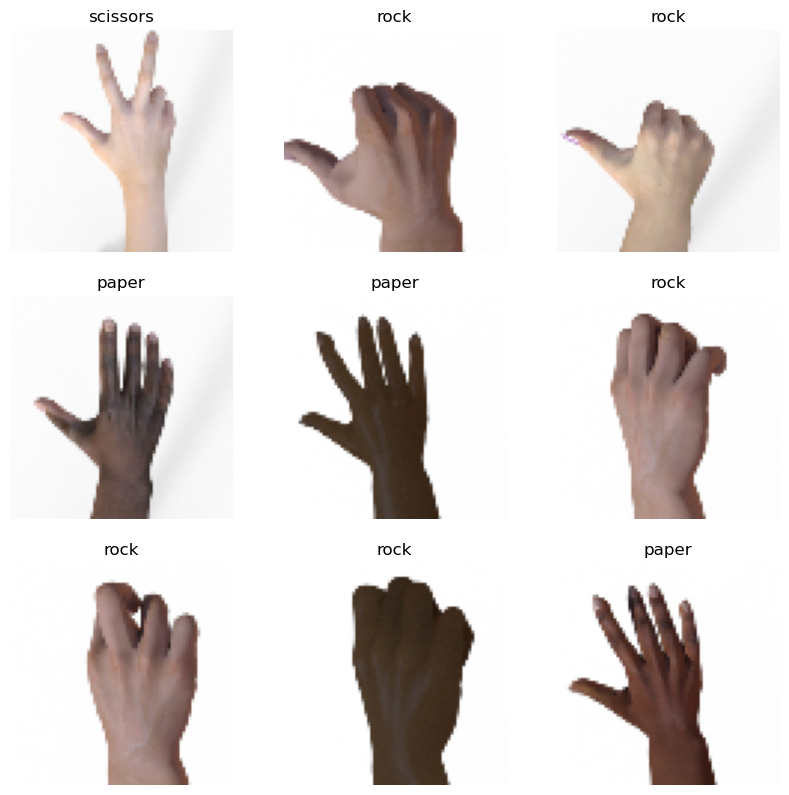

In [42]:
plt.figure(figsize=(10,10),dpi=100)
for images,labels in train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis(False)

In [43]:
scaler = keras.Sequential([keras.layers.experimental.preprocessing.Rescaling(1/255)])

In [44]:
model = keras.Sequential([ scaler,
keras.layers.Conv2D(64,kernel_size=5,strides=1,input_shape=(75, 75, 3),activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Conv2D(64,kernel_size=5,strides=1,activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Conv2D(64,kernel_size=5,strides=1,activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Flatten(),
keras.layers.Dense(2304,activation="relu"),
keras.layers.Dropout(0.2),
keras.layers.Dense(3,activation="softmax")
])

In [45]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [46]:
history = model.fit(train,validation_data=validation,epochs=10)

Epoch 1/10
63/63 [==============================] - 25s 385ms/step - loss: 0.7872 - accuracy: 0.6339 - val_loss: 0.1665 - val_accuracy: 0.9663
Epoch 2/10
63/63 [==============================] - 26s 416ms/step - loss: 0.0487 - accuracy: 0.9866 - val_loss: 0.0089 - val_accuracy: 0.9960
Epoch 3/10
63/63 [==============================] - 24s 386ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9980
Epoch 4/10
63/63 [==============================] - 25s 402ms/step - loss: 4.9113e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 22s 346ms/step - loss: 2.4821e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 32s 510ms/step - loss: 1.2816e-04 - accuracy: 1.0000 - val_loss: 6.5043e-04 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 24s 374ms/step - loss: 9.2569e-05 - accuracy: 1.0000 - val_loss: 4.2743e-0

In [47]:
model.evaluate(test)

12/12 [==============================] - 1s 69ms/step - loss: 0.4276 - accuracy: 0.8683


[0.42763036489486694, 0.8682795763015747]

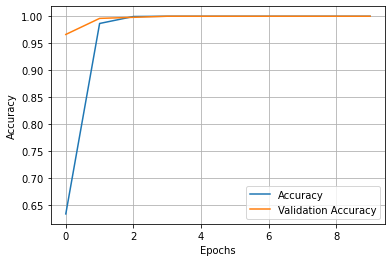

In [48]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df.accuracy,label="Accuracy")
plt.plot(history_df.val_accuracy,label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()

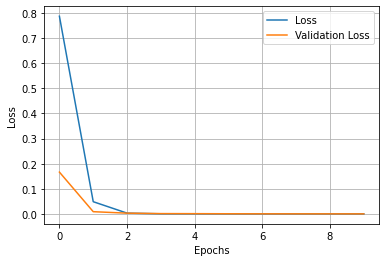

In [49]:
plt.plot(history_df.loss,label="Loss")
plt.plot(history_df.val_loss,label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred) 
sns.heatmap(confusion_mtx, annot=True, fmt='d')